In [74]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from matplotlib import colors
from astropy.io import ascii
from scipy.optimize import curve_fit
import pandas as pd
from scipy.integrate import quad
from scipy.stats import chi2
from scipy.misc import derivative
from astropy import units
from astropy import constants as const
%matplotlib inline

In [165]:
lupus_data = pd.read_csv('/Users/caleb/Hawaii_2024_REU/datasets/Table2.txt',skiprows=9)
column_names = str(lupus_data.iloc[0]).split()
column_names = column_names[1:-9]

In [170]:
column_names = ['Name',
'wle|',
 'Ftot|',
 'Ftot_e|',
 'Rc|',
 'Rc_e|',
 'gamma1|',
 'gamma1_e|',
 'gamma2|',
 'gamma2_e|',
 'inc|',
 'inc_e|',
 'PA|',
 'PA_e|',
 'rho68|' ,
 'rho68_e|',
 'R68|',
 'R68_e|',
 'ff|',
  'extraneous']

In [171]:
lupus_data = pd.read_csv('/Users/caleb/Hawaii_2024_REU/datasets/Table2.txt',skiprows=12,delim_whitespace=True)
lupus_data.columns = column_names

In [193]:
radii = list(lupus_data['R68|'])
radii_grouped = [radii[i:i + 3] for i in range(0, len(radii), 3)]

radii_errors = list(lupus_data['R68_e|'])
radii_errors_grouped = [radii_errors[i:i + 3] for i in range(0, len(radii_errors), 3)]

names = list(lupus_data['Name'])
names_grouped = [names[i:i + 3] for i in range(0, len(names), 3)]

In [194]:
# powell 2019 test data for DoAr 25

doAr25_mm = [.88, 2.8, 8, 9.8]
doAr25_radii = [215.1, 179.8, 101, 73.5]
doAr25_radii_errors = [20, 20, 20, 10]

names_grouped.append(["DoAr 25", "DoAr 25", "DoAr 25"])
radii_grouped.append(doAr25_radii)
radii_errors_grouped.append(doAr25_radii_errors)

In [184]:
def sigma_gas(r,s):


    s = np.array(s) * u.mm * (1/(2*np.pi))

    t_disk = 2 * u.Myr   # Myr
    M_star = 1.0 * u.Msun # Msun
    T0 = 123  * u.K     # midplane temperature at 1 au in K
    rho_s = 2.0 * u.g * u.cm**(-3) # internal particle density in g/cm^2
    mu = 2.33* const.m_p# mean moleculat weight (amu), from mostly hydrogen with some helium
    
    
    T = T0 * r **(-3/7)

    disk_radii = np.array(r) * u.AU
    disk_radii = disk_radii.to(u.cm) # convert Radii in AU to cm

    c_s = np.sqrt(const.k_B * T / (mu ))
    v_k = np.sqrt(const.G * M_star / (disk_radii))
    v_0 = c_s**2 / (2 * v_k)

    Sigma_gas = 2.5*t_disk *v_0 * rho_s * s / (disk_radii)
    Sigma_gas = Sigma_gas.decompose(u.cgs.bases)

    return Sigma_gas



def df_dx_sigma_gas(x):
    return derivative(sigma_gas, x, dx=1e-6)


In [185]:
# function to fit
def sigma_fit(R, Sigma0, R_crit, gamma):
    return Sigma0 / (R / R_crit)**gamma / np.exp((R / R_crit)**(2 - gamma))

# function to fit
def sigma_fit_int(R, Sigma0, R_crit, gamma):
    return 2*3.14*R*Sigma0 / (R / R_crit)**gamma / np.exp((R / R_crit)**(2 - gamma))

In [188]:
# adding in Ansdell's R_CO

R_COs = [172, 218, 388, np.nan, 146, 140,np.nan,266, np.nan, np.nan, 238, np.nan, 358, 178, 394, 462, np.nan, np.nan, 146,np.nan]
R_CO_errors = [24, 54, 84, np.nan, 18, 12, np.nan, 45, np.nan, np.nan, 66, np.nan, 52, 12, 100, 96, np.nan, np.nan, 12,np.nan]

/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_52118/820342094.py:3: RuntimeWarning: overflow encountered in exp
  return Sigma0 / (R / R_crit)**gamma / np.exp((R / R_crit)**(2 - gamma))
/Users/caleb/opt/anaconda3/envs/astron/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


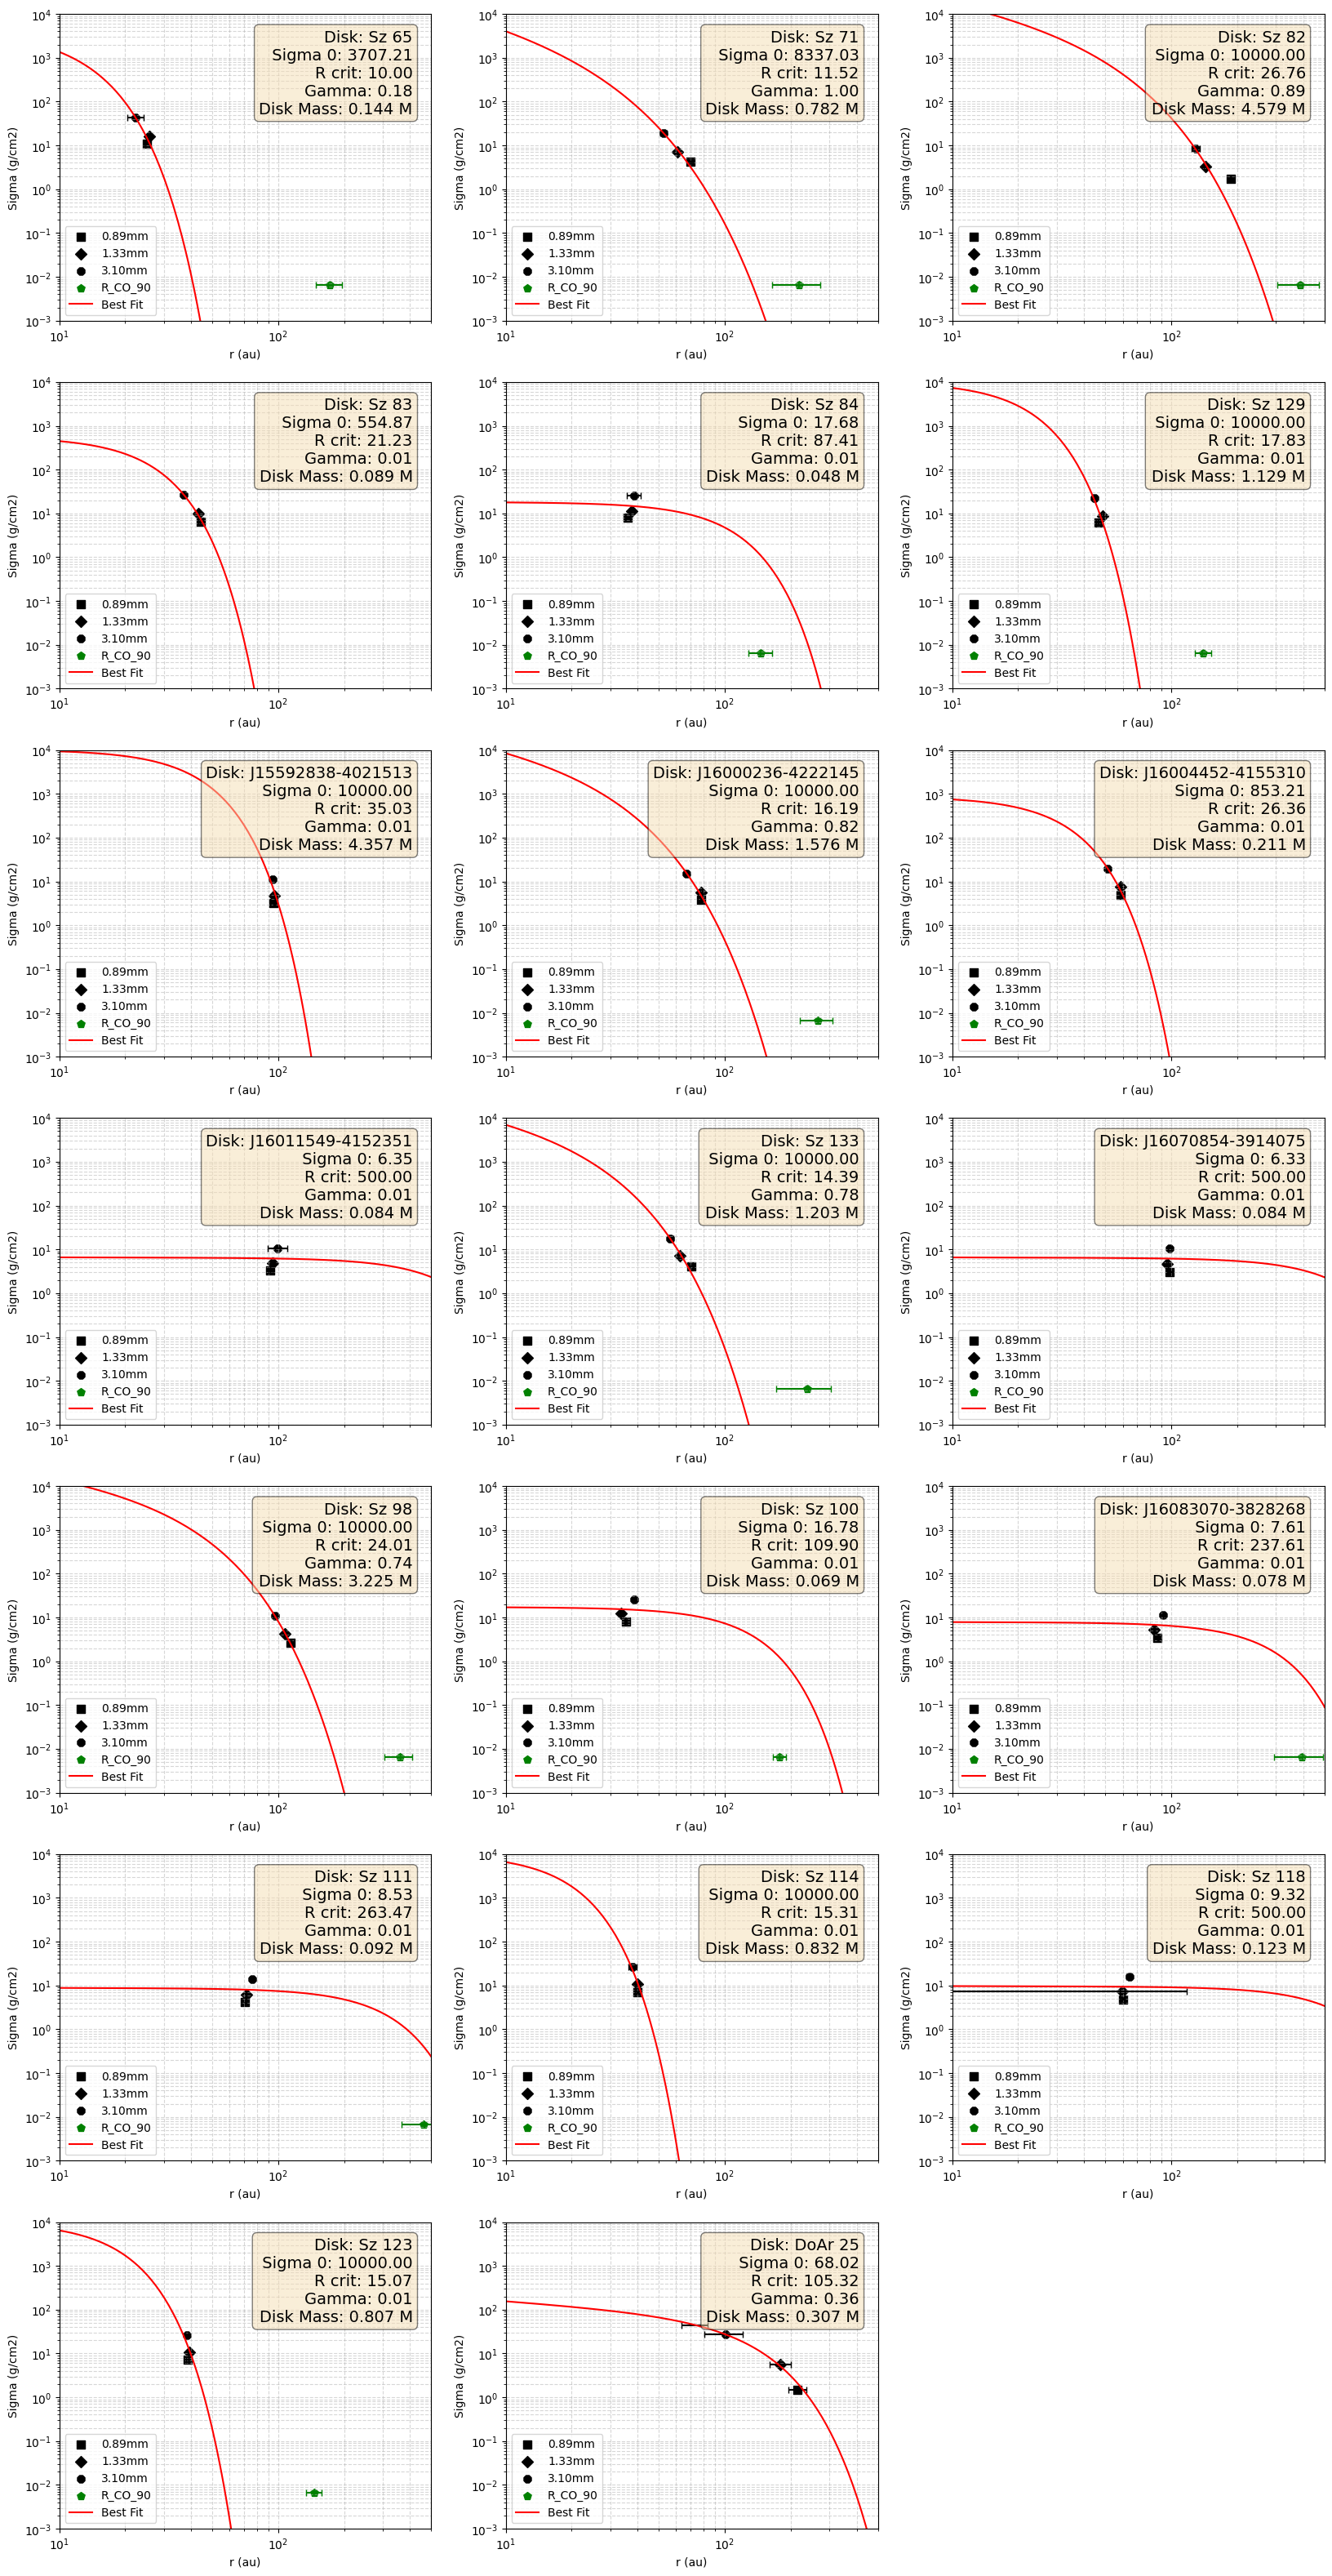

In [196]:
# function to fit
def sigma_fit(R, Sigma0, R_crit, gamma):
    return Sigma0 / (R / R_crit)**gamma / np.exp((R / R_crit)**(2 - gamma))


nrows, ncols = 7, 3

# Create figure and axes objects
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))

# Loop through the number of subplots
for idx, ax in enumerate(axes.flatten()):
    if idx < len(radii_grouped):

        disk_radii = np.array(radii_grouped[idx])
        disk_radii_errors = np.array(radii_errors_grouped[idx])

        gas_90_radius = R_COs[idx]
        gas_90_radius_error = R_CO_errors[idx]



        wavelengths = np.array([0.89, 1.33, 3.10])
        


        sigma_gas_crit = (2.33*const.m_p.to(u.g))*3.7 * 10 **21 * (.1)**(.34) * u.cm**-2
        
        try:
            sigma_gasses = sigma_gas(disk_radii, wavelengths)
            # sigma_gasses_errors = np.abs(df_dx_sigma_gas(disk_radii)) * disk_radii_errors
        except:
            sigma_gasses = sigma_gas(disk_radii, doAr25_mm)
            # sigma_gasses_errors = np.abs(df_dx_sigma_gas(disk_radii,doAr25_mm)) * disk_radii_errors


        wavelength_labels = ['0.89mm','1.33mm','3.10mm']
        marker_labels = ['s','D','8']

        for i in range(3):
            ax.scatter(disk_radii[i],  sigma_gasses[i], s=50, marker=marker_labels[i], color='black',label=wavelength_labels[i])

        ax.scatter(gas_90_radius,  sigma_gas_crit, s=50, marker='p', color='green',label='R_CO_90')


        ax.errorbar(disk_radii, sigma_gasses,xerr=radii_errors_grouped[idx], ls='none',color='black',capsize=3)
        ax.errorbar(gas_90_radius, sigma_gas_crit,xerr=gas_90_radius_error, ls='none',color='green',capsize=3)


        ax.set_xlabel('r (au)')
        ax.set_ylabel('Sigma (g/cm2)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(10, 500)
        ax.set_ylim(.001, 1e4)
        ax.grid(which='both',alpha=.5,ls='--') 


        bounds = ([5, 10, 0.01], [10000, 500, 1.0])

        if isinstance(gas_90_radius, int):
            disk_radii = np.append(disk_radii,gas_90_radius)
            sigma_gasses = np.append(sigma_gasses,sigma_gas_crit)
            popt, pcov = curve_fit(sigma_fit, disk_radii, sigma_gasses,p0=[100, 30, 0.5],maxfev=5000,bounds=bounds)
        else:
            popt, pcov = curve_fit(sigma_fit, disk_radii, sigma_gasses,p0=[100, 30, 0.5],maxfev=5000,bounds=bounds)


        # Unpack optimized parameters
        Sigma0_opt, R_crit_opt, gamma_opt = popt

        # Use optimized parameters to plot the fitted curve
        R_fit = np.logspace(1, 5, 400)
        Sigma_fit = sigma_fit(R_fit, *popt)   
        ax.plot(R_fit, Sigma_fit, '-', color='red', label='Best Fit')

        R_min = 0  # minimum radius
        R_max = 200  # maximum radius

        # Perform the integration
        area, error = quad(sigma_fit_int, R_min, R_max, args=(Sigma0_opt, R_crit_opt, gamma_opt))
        disk_mass = (area * (1.496*10**13)**2) * 5.02785*10**(-34)


        # get chi-square values
        # y_expected = sigma_fit(disk_radii, *popt)
        # chi_squared = np.sum(((sigma_gasses - y_expected) ** 2) / sigma_gasses_errors ** 2)
        # degrees_of_freedom = len(sigma_gasses) - len(popt)
        # p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)


        textstr = f'Disk: {names_grouped[idx][0].replace("_", " ")}\n Sigma 0: {Sigma0_opt:.2f}\nR crit: {R_crit_opt:.2f}\nGamma: {gamma_opt:.2f}\nDisk Mass: {disk_mass:.3f} M'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



        # Place a text box in upper left in axes coords
        ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props, horizontalalignment='right')

        # Optionally add a legend
        ax.legend(loc='lower left')

    else:
        ax.axis('off')  # Turn off axis for empty subplots

plt.savefig("lupus_masses.png")